# Libraries

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import missingno

# dates
import datetime
from matplotlib.dates import DateFormatter

# text analysis
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist as fdist
import re

# statistical analysis
from scipy.stats import ttest_ind

# warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to C:\Users\Jason
[nltk_data]     Chong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
pwd

'C:\\Users\\Jason Chong'

# Load data

In [4]:
customerData = pd.read_csv("C:/Users/Jason Chong/Documents/Inside Sherpa Quantium/QVI_purchase_behaviour.csv")
transactionData = pd.read_csv("C:/Users/Jason Chong/Documents/Inside Sherpa Quantium/QVI_transaction_data.csv")

# Transaction data

In [4]:
transactionData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [3]:
len(transactionData)

NameError: name 'transactionData' is not defined

In [6]:
transactionData['TXN_ID'].nunique()

# Comment: 'TXN_ID' is not unique to each row which means a customer can buy multiple brands of chips in a single trasaction
# Each row of the data corresponds to purchase of a single brand of chips and a customer can buy multiple brands in one single transaction

263127

In [7]:
transactionData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


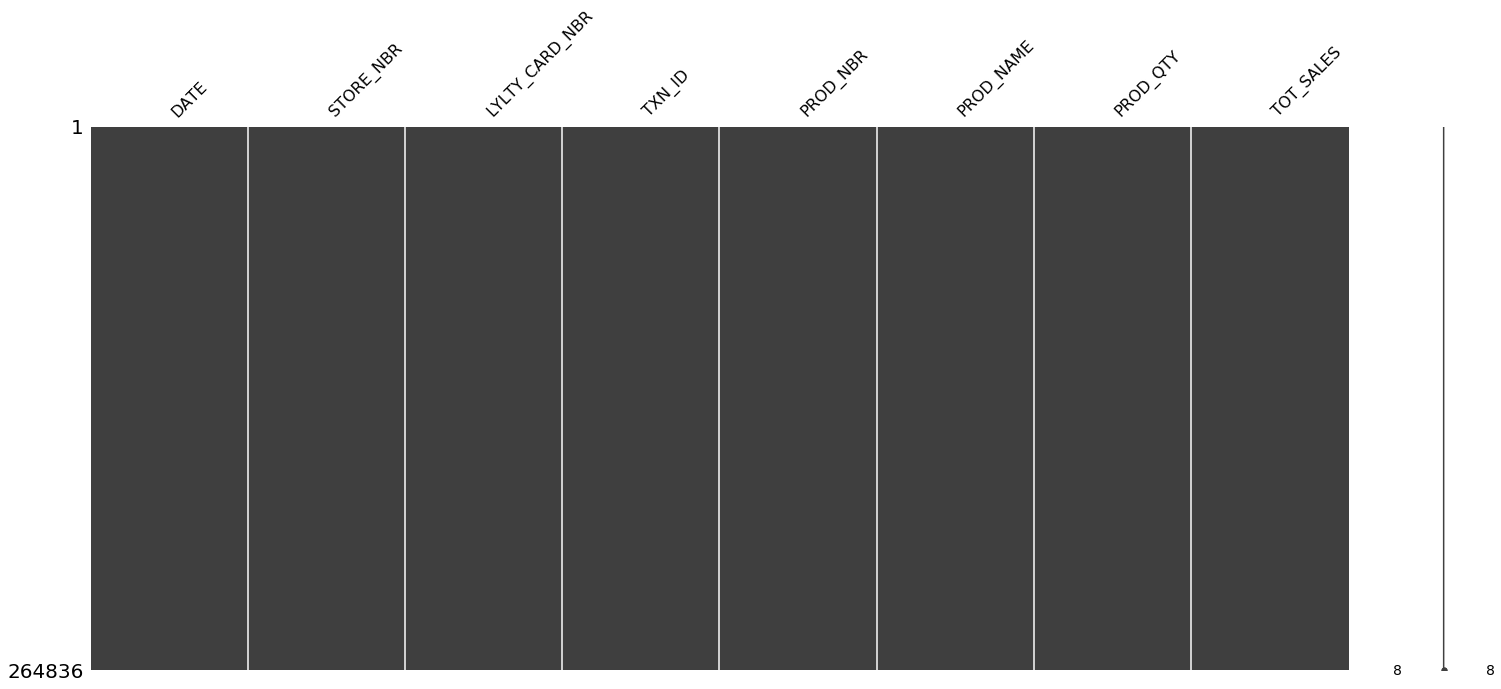

In [8]:
# Plot graph of missing values for 'transactionData'

missingno.matrix(transactionData)

# Comment: no missing numbers in transaction data 

In [9]:
# Now let's explore the features in both dataset starting with 'transactionData'

list(transactionData.columns)

['DATE',
 'STORE_NBR',
 'LYLTY_CARD_NBR',
 'TXN_ID',
 'PROD_NBR',
 'PROD_NAME',
 'PROD_QTY',
 'TOT_SALES']

In [10]:
transactionData['DATE'].head()

0    43390
1    43599
2    43605
3    43329
4    43330
Name: DATE, dtype: int64

In [11]:
# 'Date' is not in the right format

# Function that converts Excel integer into yyyy-mm-dd format
def xlseriesdate_to_datetime(xlserialdate):
    excel_anchor = datetime.datetime(1900, 1, 1)
    if(xlserialdate < 60):
        delta_in_days = datetime.timedelta(days = (xlserialdate - 1))
    else:
        delta_in_days = datetime.timedelta(days = (xlserialdate - 2))
    converted_date = excel_anchor + delta_in_days
    return converted_date

In [12]:
# Apply function to 'DATE' feature in 'transactionData' dataset

transactionData['DATE'] = transactionData['DATE'].apply(xlseriesdate_to_datetime)

In [13]:
# Check the first 5 rows of the new feature

transactionData['DATE'].head()

0   2018-10-17
1   2019-05-14
2   2019-05-20
3   2018-08-17
4   2018-08-18
Name: DATE, dtype: datetime64[ns]

In [14]:
# Date is now in the right format

transactionData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [15]:
# Let's move on to 'PROD_NAME' feature

transactionData['PROD_NAME'].head()

0      Natural Chip        Compny SeaSalt175g
1                    CCs Nacho Cheese    175g
2      Smiths Crinkle Cut  Chips Chicken 170g
3      Smiths Chip Thinly  S/Cream&Onion 175g
4    Kettle Tortilla ChpsHny&Jlpno Chili 150g
Name: PROD_NAME, dtype: object

In [16]:
# Extract weights out of 'PROD_NAME'

transactionData['PACK_SIZE'] = transactionData['PROD_NAME'].str.extract("(\d+)")
transactionData['PACK_SIZE'] = pd.to_numeric(transactionData['PACK_SIZE'])
transactionData['PACK_SIZE'].head()

0    175
1    175
2    170
3    175
4    150
Name: PACK_SIZE, dtype: int64

In [17]:
# Create text cleaning function for 'PROD_NAME' feature
def clean_text(text):
    text = re.sub('[&/]', ' ', text) # remove special characters '&' and '/'
    text = re.sub('\d\w*', ' ', text) # remove product weights
    return text

# Apply text cleaning function to 'PROD_NAME' column
transactionData['PROD_NAME'] = transactionData['PROD_NAME'].apply(clean_text)

In [18]:
# Create one giant string and apply 'word_tokenize' to separate the words

cleanProdName = transactionData['PROD_NAME']
string = ''.join(cleanProdName)
prodWord = word_tokenize(string)

In [19]:
# Apply 'fdist' function which computes the frequency of each token and put it into a dataframe

wordFrequency = fdist(prodWord)
freq_df = pd.DataFrame(list(wordFrequency.items()), columns = ["Word", "Frequency"]).sort_values(by = 'Frequency', ascending = False)

In [20]:
# Let's see the top 5 most frequent words

freq_df.head()

,Word,Frequency
10,Chips,49770
16,Kettle,40739
7,Smiths,28572
6,Cheese,27890
66,Pringles,24743


In [21]:
# Drop rows with 'salsa' in 'PROD_NAME'

transactionData['PROD_NAME'] = transactionData['PROD_NAME'].apply(lambda x: x.lower())
transactionData = transactionData[~transactionData['PROD_NAME'].str.contains("salsa")]
transactionData['PROD_NAME'] = transactionData['PROD_NAME'].apply(lambda x: x.title())


In [22]:
# Let's have a look at our data table again

transactionData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
0,2018-10-17,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175
1,2019-05-14,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S Cream Onion,5,15.0,175
4,2018-08-18,2,2426,1038,108,Kettle Tortilla Chpshny Jlpno Chili,3,13.8,150


In [23]:
# We shall explore 'PROD_QTY' and 'TOT_SALES' feature next

transactionData['PROD_QTY'].value_counts()

# Max of 200 looks odd

2      220070
1       25476
5         415
3         408
4         371
200         2
Name: PROD_QTY, dtype: int64

In [24]:
# We have two occurrences of 200 in the dataset
# Let's explore further

transactionData.loc[transactionData['PROD_QTY'] == 200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme,200,650.0,380
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme,200,650.0,380


In [25]:
# Both these transactions have been made by the same person at the same store
# Let's see all the transactions this person has made by tracking his loyalty card number '226000'

transactionData.loc[transactionData['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme,200,650.0,380
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme,200,650.0,380


In [26]:
# This person only made two transactions over the entire year so unlikely to be a retail customer 
# He or she is most likely purchasing for commercial purposes
# Safe to drop these this customer in both 'transactionData' and 'customerData' dataset

transactionData.drop(transactionData.index[transactionData['LYLTY_CARD_NBR'] == 226000], inplace = True)
customerData.drop(customerData.index[customerData['LYLTY_CARD_NBR'] == 226000], inplace = True)

In [27]:
# Make sure it has been dropped 

transactionData.loc[transactionData['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE


In [28]:
# Now let's examine the number of transactions over time to see if there are any obvious data issues e.g. missing data

transactionData['DATE'].nunique()

364

In [29]:
# Look for the missing date 
# Turns out that it was Christmas Day so it makes sense because most retail stores are closed on that day

pd.date_range(start = '2018-07-01', end = '2019-06-30').difference(transactionData['DATE'])

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)

In [30]:
# Create a new dataframe which contains the total sale for each date

a = pd.pivot_table(transactionData, values = 'TOT_SALES', index = 'DATE', aggfunc = 'sum')
a.head()

,TOT_SALES
DATE,
2018-07-01,4920.1
2018-07-02,4877.0
2018-07-03,4954.7
2018-07-04,4968.1
2018-07-05,4682.0


In [31]:
b = pd.DataFrame(index = pd.date_range(start = '2018-07-01', end = '2019-06-30'))
b['TOT_SALES'] = 0
b

,TOT_SALES
2018-07-01,0
2018-07-02,0
2018-07-03,0
2018-07-04,0
2018-07-05,0
...,...
2019-06-26,0
2019-06-27,0
2019-06-28,0
2019-06-29,0


In [32]:
c = a+b
c.fillna(0, inplace = True)

In [33]:
c.head()

,TOT_SALES
2018-07-01,4920.1
2018-07-02,4877.0
2018-07-03,4954.7
2018-07-04,4968.1
2018-07-05,4682.0


In [34]:
c.index.name = 'Date'
c.rename(columns = {'TOT_SALES': 'Total Sales'}, inplace = True)
c.head() 

,Total Sales
Date,
2018-07-01,4920.1
2018-07-02,4877.0
2018-07-03,4954.7
2018-07-04,4968.1
2018-07-05,4682.0


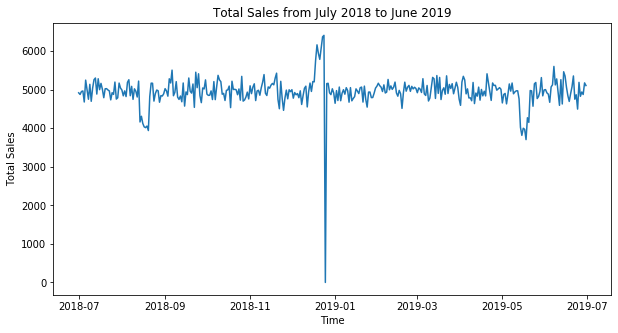

In [35]:
timeline = c.index
graph = c['Total Sales']

fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(timeline, graph)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.title('Total Sales from July 2018 to June 2019')
plt.xlabel('Time')
plt.ylabel('Total Sales')

plt.show()

# Comment: We can see that sales spike up during the December month and zero sale on Christmas

In [36]:
# Confirm the date where sales count equals to zero

c[c['Total Sales'] == 0]

# It is indeed Christmas Day

,Total Sales
Date,
2018-12-25,0.0


In [37]:
# Let's look at the December month only

c_december = c[(c.index < "2019-01-01") & (c.index > "2018-11-30")]
c_december.head()

,Total Sales
Date,
2018-12-01,5000.9
2018-12-02,4781.1
2018-12-03,4927.0
2018-12-04,4869.4
2018-12-05,4900.5


Text(0.5, 1.0, 'Total Sales in December')

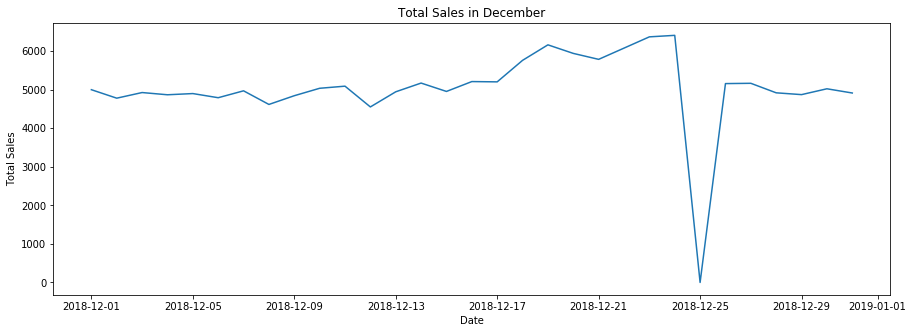

In [38]:
plt.figure(figsize = (15, 5))
plt.plot(c_december)
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales in December')

In [39]:
# Reset index for 'c_december'

c_december.reset_index(drop = True, inplace = True)
c_december.head()

,Total Sales
0,5000.9
1,4781.1
2,4927.0
3,4869.4
4,4900.5


In [40]:
# Relabel 'Date'

c_december['Date'] = c_december.index + 1
c_december.head()

,Total Sales,Date
0,5000.9,1
1,4781.1,2
2,4927.0,3
3,4869.4,4
4,4900.5,5


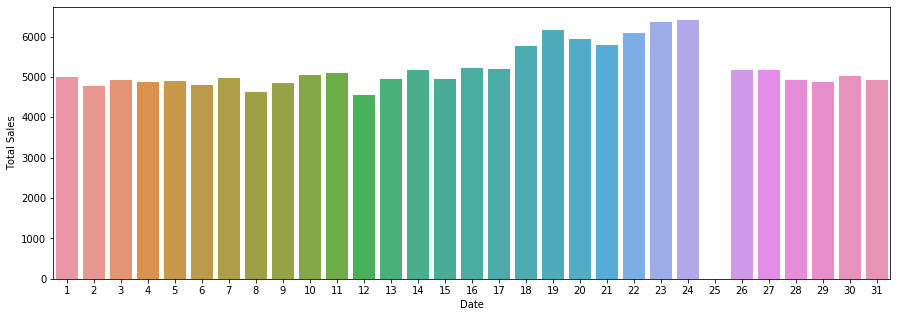

In [41]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'Date', y ='Total Sales', data = c_december)

# Comment: No sales on Christmas Day (2018-12-25)

In [42]:
# Now that we are satisfied that the data no longer has outliers
# We can move on to creating other features
# At the beginning, we have already created a 'pack_size' feature
# Let's have a look again

transactionData['PACK_SIZE'].head()

0    175
1    175
2    170
3    175
4    150
Name: PACK_SIZE, dtype: int64

In [43]:
transactionData['PACK_SIZE'].unique()

# Comment: the largest size is 380g and the smallest size is 70g which seems reasonable

array([175, 170, 150, 330, 210, 270, 220, 125, 110, 134, 380, 180, 165,
       135, 250, 200, 160, 190,  90,  70], dtype=int64)

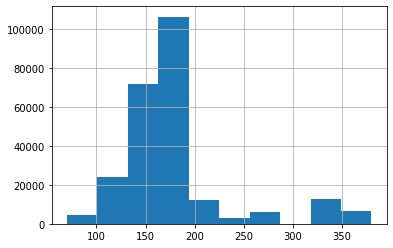

In [44]:
# Check the distribution of 'PACK_SIZE'

transactionData['PACK_SIZE'].hist()

In [45]:
# Extract brand name from 'PROD_NAME' 
# Create a new column under 'TransactionData' called 'brand'

part = transactionData['PROD_NAME'].str.partition()
transactionData['BRAND'] = part[0]
transactionData['BRAND'].head()

0    Natural
1        Ccs
2     Smiths
3     Smiths
4     Kettle
Name: BRAND, dtype: object

In [46]:
transactionData['BRAND'].unique()

array(['Natural', 'Ccs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'Ww', 'Thins', 'Burger', 'Ncc', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'Grnwves',
       'Tyrrells', 'Cobs', 'French', 'Rrd', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

In [47]:
# It looks like there are duplicates of the same brand e.g. 'ww' and 'woolworths', 'red' and 'rrd', 'natural' and 'ncc', 
# 'infuzions' and 'infzns', 'snbts' and 'sunbites', 'grain' and 'grnwves', 'smiths' and 'smith', 'doritos' and 'dorito'
# Let's rename them for consistency

transactionData['BRAND'].replace(['Natural', 'Ncc'], 'Natural', inplace = True)
transactionData['BRAND'].replace('Ccs', 'CCS', inplace = True)
transactionData['BRAND'].replace(['Smiths', 'Smith'], 'Smiths', inplace = True)
transactionData['BRAND'].replace(['Grain', 'Grnwves'], 'Grainwaves', inplace = True)
transactionData['BRAND'].replace(['Doritos', 'Dorito'], 'Doritos', inplace = True)
transactionData['BRAND'].replace(['Ww', 'Woolworths'], 'Woolworths', inplace = True)
transactionData['BRAND'].replace('Infzns', 'Infuzions', inplace = True)
transactionData['BRAND'].replace(['Red', 'Rrd'], 'Red Rock Deli', inplace = True)
transactionData['BRAND'].replace('Snbts', 'Sunbites', inplace = True)

transactionData['BRAND'].unique()

array(['Natural', 'CCS', 'Smiths', 'Kettle', 'Grainwaves', 'Doritos',
       'Twisties', 'Woolworths', 'Thins', 'Burger', 'Cheezels',
       'Infuzions', 'Red Rock Deli', 'Pringles', 'Tyrrells', 'Cobs',
       'French', 'Tostitos', 'Cheetos', 'Sunbites'], dtype=object)

In [48]:
# Which brand had the most sales?

transactionData.groupby('BRAND').TOT_SALES.sum().sort_values(ascending = False)

BRAND
Kettle           390239.8
Doritos          226329.9
Smiths           217492.0
Pringles         177655.5
Infuzions         99047.6
Thins             88852.5
Red Rock Deli     87607.5
Twisties          81522.1
Tostitos          79789.6
Cobs              70569.8
Tyrrells          51647.4
Grainwaves        51617.2
Natural           42318.0
Woolworths        41059.1
Cheezels          40029.9
CCS               18078.9
Cheetos           16884.5
Sunbites           9676.4
French             7929.0
Burger             6831.0
Name: TOT_SALES, dtype: float64

# Customer Data

In [49]:
# Let's move on to 'customerData' dataset now

list(customerData.columns)

['LYLTY_CARD_NBR', 'LIFESTAGE', 'PREMIUM_CUSTOMER']

In [50]:
customerData.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


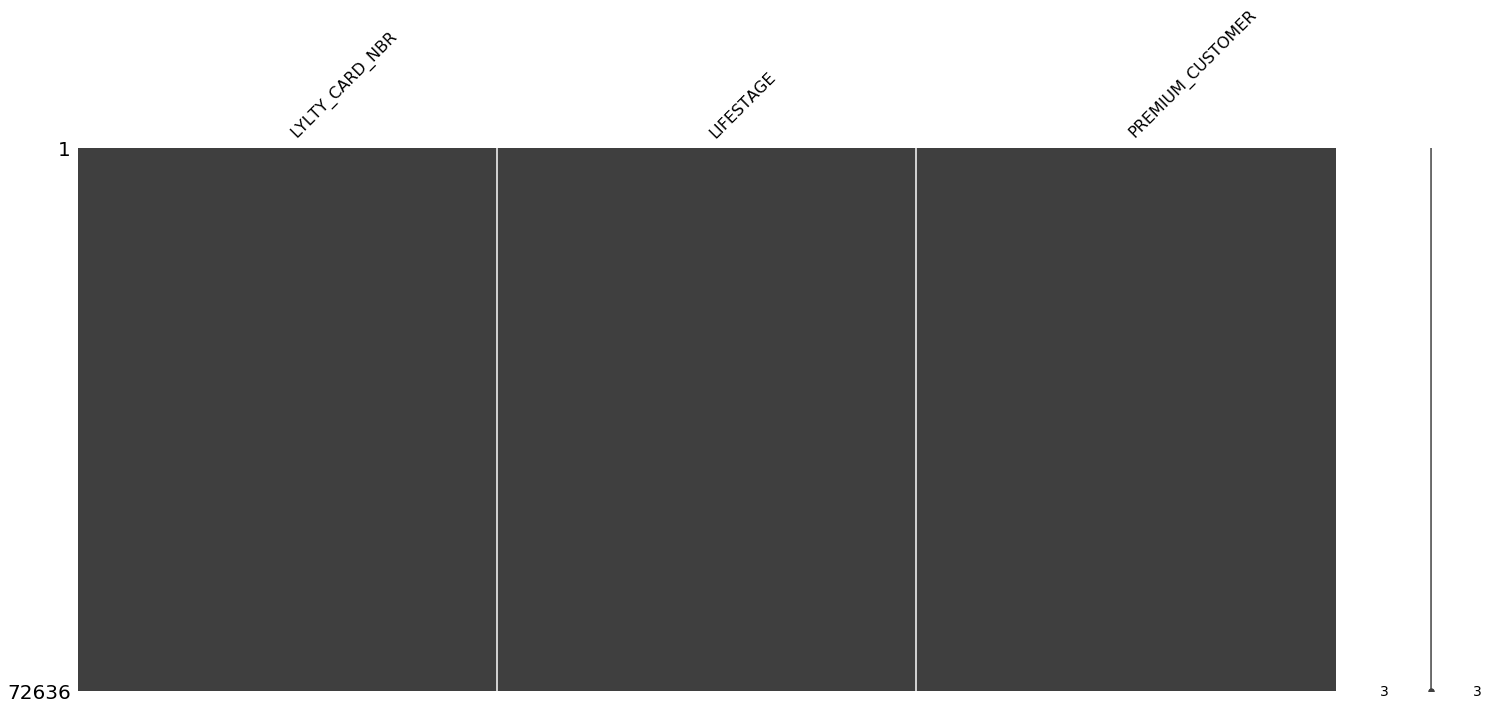

In [51]:
missingno.matrix(customerData)

In [52]:
len(customerData)

72636

In [53]:
customerData['LYLTY_CARD_NBR'].nunique()

# Comment: 'LYLTY_CARD_NBR' is unique to each row

72636

In [54]:
customerData['LIFESTAGE'].nunique()

# Comment: 7 unique lifestages of customers

7

In [55]:
# Let's see what those lifestages are

customerData['LIFESTAGE'].unique()

array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
       'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
       'RETIREES'], dtype=object)

In [56]:
# Counts for each lifestages

customerData['LIFESTAGE'].value_counts().sort_values(ascending = False)

RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9779
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64

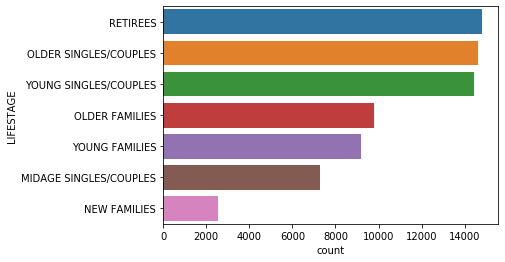

In [57]:
sns.countplot(y = customerData['LIFESTAGE'], order = customerData['LIFESTAGE'].value_counts().index)

In [58]:
# What about the 'PREMIUM_CUSTOMER' column

customerData['PREMIUM_CUSTOMER'].nunique()

3

In [59]:
# Counts for each 'PREMIUM_CUSTOMER'

customerData['PREMIUM_CUSTOMER'].value_counts().sort_values(ascending = False)

# Comment: Mainstream has the highest count, followed by budget and finally premium

Mainstream    29245
Budget        24470
Premium       18921
Name: PREMIUM_CUSTOMER, dtype: int64

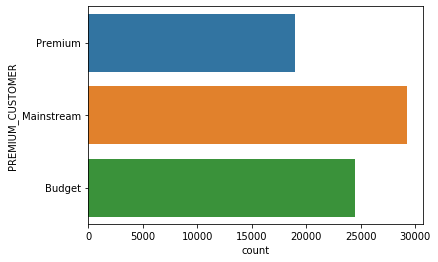

In [64]:
# Visualise 'PREMIUM_CUSTOMER'

sns.countplot(y = customerData['PREMIUM_CUSTOMER'])

In [ ]:
# Now let's merge the two datasets together
# Before we do, examine the shape

transactionData.shape

In [ ]:
customerData.shape

In [ ]:
combineData = pd.merge(transactionData, customerData)
combineData.shape

In [ ]:
# The two datasets are joined together via the column 'LYLTY_CARD_NBR'

combineData.head()

In [ ]:
# Check for null values

combineData.isnull().sum()

# Data analysis on customer segments

Now that our data is ready for analysis, we can define some metrics of interest to the client:

- Who spends the most on chips, describing customers by lifestage and how premium their general purchasing behaviour is
- How many customers are in each segment
- How many chips are bought per customer by segment
- What is the average chip price by customer segment
    

In [ ]:
# Total sales by 'PREMIUM_CUSTOMER' and 'LIFESTAGE'

sales = pd.DataFrame(combineData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).TOT_SALES.sum())
sales.rename(columns = {'TOT_SALES': 'Total Sales'}, inplace = True)
sales.sort_values(by = 'Total Sales', ascending = False, inplace = True)
sales

In [ ]:
# Visualise
salesPlot = pd.DataFrame(combineData.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).TOT_SALES.sum())
salesPlot.unstack().plot(kind = 'bar', stacked = True, figsize = (10, 5), title = 'Total Sales by Customer Segment')

# Comment: Sales are coming from budget older families, mainstream young singles/couples and mainstream retirees

In [ ]:
# Let's see if the higher sales are due to there being more customers who buy chips
# Number of customers by 'PREMIUM_CUSTOMER' and 'LIFESTAGE'
# Remember to take unique 'LYLTY_CARD_NBR'

customers = pd.DataFrame(combineData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).LYLTY_CARD_NBR.nunique())
customers.rename(columns = {'LYLTY_CARD_NBR': 'Number of Customers'}, inplace = True)
customers.sort_values(by = 'Number of Customers', ascending = False).head()

In [ ]:
# Visualise
customersPlot = pd.DataFrame(combineData.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique())
customersPlot.unstack().plot(kind = 'bar', stacked = True, figsize = (10, 5), title = 'Number of Customers by Customer Segment')

# Comment: There are more mainstream young singles/couples and retirees. This contributes to to more chips sales in these
# segments however this is not the major driver for the budget older families segment

In [ ]:
# Higher sales may also be driven by more units of chips being bought per customer
# Let's calculate the average units per customer by 'PREMIUM_CUSTOMER' and 'LIFESTAGE'
# Total quantity sold divided by unique customers

avg_units = combineData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).PROD_QTY.sum() / combineData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).LYLTY_CARD_NBR.nunique()
avg_units = pd.DataFrame(avg_units, columns = {'Average Unit per Customer'})
avg_units.sort_values(by = 'Average Unit per Customer', ascending = False).head()

In [ ]:
# Visualise 
avgUnitsPlot = pd.DataFrame(combineData.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).PROD_QTY.sum() / combineData.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique())
avgUnitsPlot.unstack().plot(kind = 'bar', figsize = (10, 5), title = 'Average Unit by Customer Segment')

# Comment: Older families and young families buy more chips per customer

In [ ]:
# Let's also investigate the average price per unit chips bought for each customer segment as this is also a driver of total sales
# Total sales divided by total quantity purchased

# Average price per unit by 'PREMIUM_CUSTOMER' and 'LIFESTAGE'
avg_price = combineData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).TOT_SALES.sum() / combineData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).PROD_QTY.sum()
avg_price = pd.DataFrame(avg_price, columns = {'Price per Unit'})
avg_price.sort_values(by = 'Price per Unit', ascending = False).head()


In [ ]:
# Visualise 
avgPricePlot = pd.DataFrame(combineData.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).TOT_SALES.sum() / combineData.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).PROD_QTY.sum())
avgPricePlot.unstack().plot(kind = 'bar', figsize = (10, 5), title = 'Average Price by Customer Segment', ylim = (0, 6))

# Comment: Mainstream midage and young singles and couples are more willing to pay more per packet of chips compared to their 
# budget and premium counterparts. This may be due to premium shoppers being more likely to buy healthy snacks and when
# they do buy chips, it is mainly for entertainment purposes rather than their own consumption. This is also supported by
# there being fewer premium midage and young singles and couples buying chips compared to their mainstream counterparts

In [ ]:
# As this difference in average price per unit is not too large 
# Perform an independent t-test between mainstream vs non-mainstream midage and young singles/couples

# Create a new dataframe 'pricePerUnit'
pricePerUnit = combineData

# Create a new column under 'pricePerUnit' called 'PRICE'
pricePerUnit['PRICE'] = pricePerUnit['TOT_SALES'] / pricePerUnit['PROD_QTY']

# Let's have a look
pricePerUnit.head()

In [ ]:
# Let's group our data into mainstream and non-mainstream

mainstream = pricePerUnit.loc[(pricePerUnit['PREMIUM_CUSTOMER'] == 'Mainstream') & ( (pricePerUnit['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (pricePerUnit['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') ), 'PRICE']
nonMainstream = pricePerUnit.loc[(pricePerUnit['PREMIUM_CUSTOMER'] != 'Mainstream') & ( (pricePerUnit['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (pricePerUnit['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') ), 'PRICE']

In [ ]:
plt.figure(figsize = (10, 5))
plt.hist(mainstream, label = 'Mainstream')
plt.hist(nonMainstream, label = 'Premium & Budget')
plt.legend()
plt.xlabel('Price per Unit')

In [ ]:
# Let's have a look at their means

[np.mean(mainstream), np.mean(nonMainstream)]

# Mainstream has a higher average price per unit

In [ ]:
# Perform t-test 

ttest_ind(mainstream, nonMainstream)

# Comment: Mainstream price per unit is significantly higher than non-mainstream 

In [ ]:
# Deep dive into specific customer segment for insights
# We have found quite a few interesting insights that we can dive deeper into 
# For example, we might want to target customers segments that contribute the most to sales to retain them to further increase sales
# Let's examine mainstream young singles/couples against the rest of the cutomer segments to see if they prefer any particular brand of chips

target = combineData.loc[(combineData['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (combineData['PREMIUM_CUSTOMER'] == 'Mainstream'), :]
nonTarget = combineData.loc[(combineData['LIFESTAGE'] != 'YOUNG SINGLES/COUPLES' ) & (combineData['PREMIUM_CUSTOMER'] != 'Mainstream'), :]
target.head()

In [ ]:
# Affinity to brand

# Target Segment
targetBrand = target.loc[:, ['BRAND', 'PROD_QTY']]
targetSum = targetBrand['PROD_QTY'].sum()
targetBrand['Target Brand Affinity'] = targetBrand['PROD_QTY'] / targetSum
targetBrand = pd.DataFrame(targetBrand.groupby('BRAND')['Target Brand Affinity'].sum())

# Non-target segment
nonTargetBrand = nonTarget.loc[:, ['BRAND', 'PROD_QTY']]
nonTargetSum = nonTargetBrand['PROD_QTY'].sum()
nonTargetBrand['Non-Target Brand Affinity'] = nonTargetBrand['PROD_QTY'] / nonTargetSum
nonTargetBrand = pd.DataFrame(nonTargetBrand.groupby('BRAND')['Non-Target Brand Affinity'].sum())

In [ ]:
# Merge the two dataframes together

brand_proportions = pd.merge(targetBrand, nonTargetBrand, left_index = True, right_index = True)
brand_proportions.head()

In [ ]:
brand_proportions['Affinity to Brand'] = brand_proportions['Target Brand Affinity'] / brand_proportions['Non-Target Brand Affinity']
brand_proportions.sort_values(by = 'Affinity to Brand', ascending = False)

In [ ]:
# Comment: Mainstream young singles/couples are more likely to purchase Tyrrells chips compared to other brands

In [ ]:
# Affinity to pack size

# Target Segment
targetSize = target.loc[:, ['PACK_SIZE', 'PROD_QTY']]
targetSum = targetSize['PROD_QTY'].sum()
targetSize['Target Pack Affinity'] = targetSize['PROD_QTY'] / targetSum
targetSize = pd.DataFrame(targetSize.groupby('PACK_SIZE')['Target Pack Affinity'].sum())

# Non-target segment
nonTargetSize = nonTarget.loc[:, ['PACK_SIZE', 'PROD_QTY']]
nonTargetSum = nonTargetSize['PROD_QTY'].sum()
nonTargetSize['Non-Target Pack Affinity'] = nonTargetSize['PROD_QTY'] / nonTargetSum
nonTargetSize = pd.DataFrame(nonTargetSize.groupby('PACK_SIZE')['Non-Target Pack Affinity'].sum())

In [ ]:
# Merge the two dataframes together

pack_proportions = pd.merge(targetSize, nonTargetSize, left_index = True, right_index = True)
pack_proportions.head()

In [ ]:
pack_proportions['Affinity to Pack'] = pack_proportions['Target Pack Affinity'] / pack_proportions['Non-Target Pack Affinity']
pack_proportions.sort_values(by = 'Affinity to Pack', ascending = False)

In [ ]:
# Comment: It looks like mainstream singles/couples are more likely to purchase a 270g pack size compared to other pack sizes

In [ ]:
# Which brand offers 270g pack size

combineData.loc[combineData['PACK_SIZE'] == 270, :].head(10)

In [ ]:
# Is Twisties the only brand who sells 270g pack size

combineData.loc[combineData['PACK_SIZE'] == 270, 'BRAND'].unique()

# Twisties is the only brand that offers 270g pack size 

# Conclusion

- Sales are highest for (Budget, OLDER FAMILIES), (Mainstream, YOUNG SINGLES/COUPLES) and (Mainstream, RETIREES)
- We found that (Mainstream, YOUNG SINGLES/COUPLES) and (Mainstream, RETIREES) are mainly due to the fact that there are more customers in these segments
- (Mainstream, YOUNG SINGLES/COUPLES) are more likely to pay more per packet of chips than their premium and budget counterparts
- They are also more likely to purchase 'Tyrrells' and '270g' pack sizes than the rest of the population

# Recommendation

The category manager may consider off-locating 'Tyrrells' chips in discretionary space near segments where young singles and couples frequent to increase the visibility and impulse behaviour